In [166]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Data Loading

In [167]:
df = pd.read_excel('premiums_rest.xlsx')

In [168]:
df.shape

(29904, 13)

In [169]:
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610


In [170]:
df['genetical_risk'] = 0

# Data Cleaning & EDA

In [171]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount', 'genetical_risk'],
      dtype='object')

### Making the column names consistent 

In [172]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [173]:
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount', 'genetical_risk'],
      dtype='object')

### Handling Null values

In [174]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [175]:
# Droping Null entries since the number of null entries are small

df.dropna(inplace=True)

In [176]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29886.000000,29886.000000,29886.000000,29886.000000,29886.0
mean,43.396105,2.379910,23.364184,20892.303821,0.0
std,13.412657,1.431201,24.740339,6936.813440,0.0
min,26.000000,-3.000000,1.000000,3625.000000,0.0
25%,34.000000,1.000000,7.000000,15697.250000,0.0
50%,42.000000,3.000000,17.000000,20489.000000,0.0
75%,52.000000,3.000000,32.000000,26360.000000,0.0
max,356.000000,5.000000,930.000000,43471.000000,0.0


we can identify outliers in age, number of dependents and income

### Handling Outliers

In [177]:
numerical_columns = df.select_dtypes(['int64', 'float64']).columns

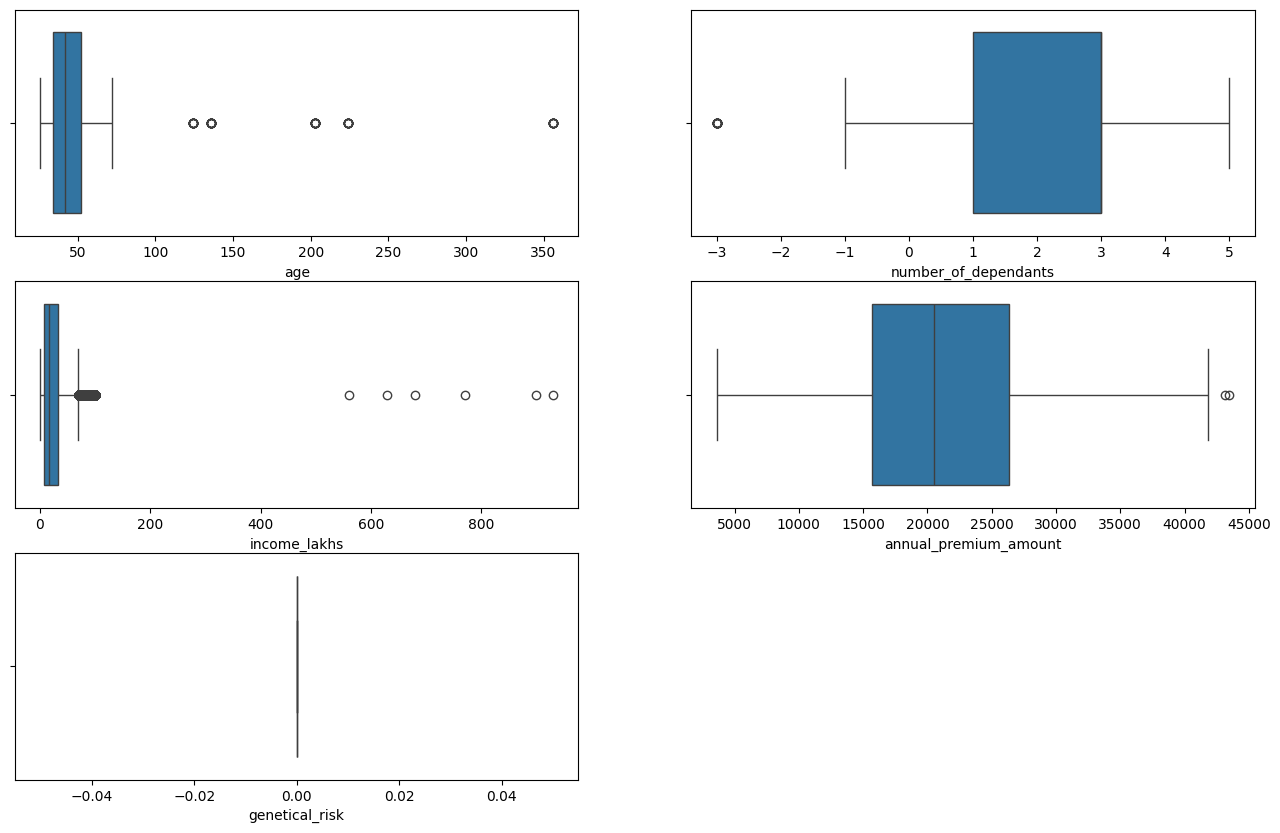

In [178]:
# Box plot to visualize outliers

plt.figure(figsize=(16,10))
for idx, col in enumerate(numerical_columns):
    plt.subplot(3,2,idx+1)
    sns.boxplot(data=df, x=col)
plt.show()  

In [179]:
# Number of dependents cannot be negative

df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    29886.000000
mean         2.385933
std          1.421137
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

In [180]:
# Conisder max age to be 100 

df[df['age'] > 100].shape[0]

58

In [181]:
# Dropping entries with age > 100

df = df[df['age'] <= 100]
df.age.describe()

count    29828.000000
mean        43.095380
std         11.041991
min         26.000000
25%         34.000000
50%         42.000000
75%         52.000000
max         72.000000
Name: age, dtype: float64

In [182]:
def get_iqr_range(col):
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    return lower_bound, upper_bound

In [183]:
lower, upper = get_iqr_range('income_lakhs')
lower, upper

# Here is ther upper bound for income is 67 lpa

(-30.5, 69.5)

In [184]:
income_upper_bound = df['income_lakhs'].quantile(0.999)

In [185]:
df[df['income_lakhs'] > income_upper_bound].shape[0]

6

In [186]:
# Conside 1 Cr as upper bound for income per year and Droping income outliers

df = df[df['income_lakhs'] <= income_upper_bound]

In [187]:
df.income_lakhs.describe()

count    29822.000000
mean        23.226343
std         22.455408
min          1.000000
25%          7.000000
50%         17.000000
75%         32.000000
max        100.000000
Name: income_lakhs, dtype: float64

### Distribution of Numerical columns

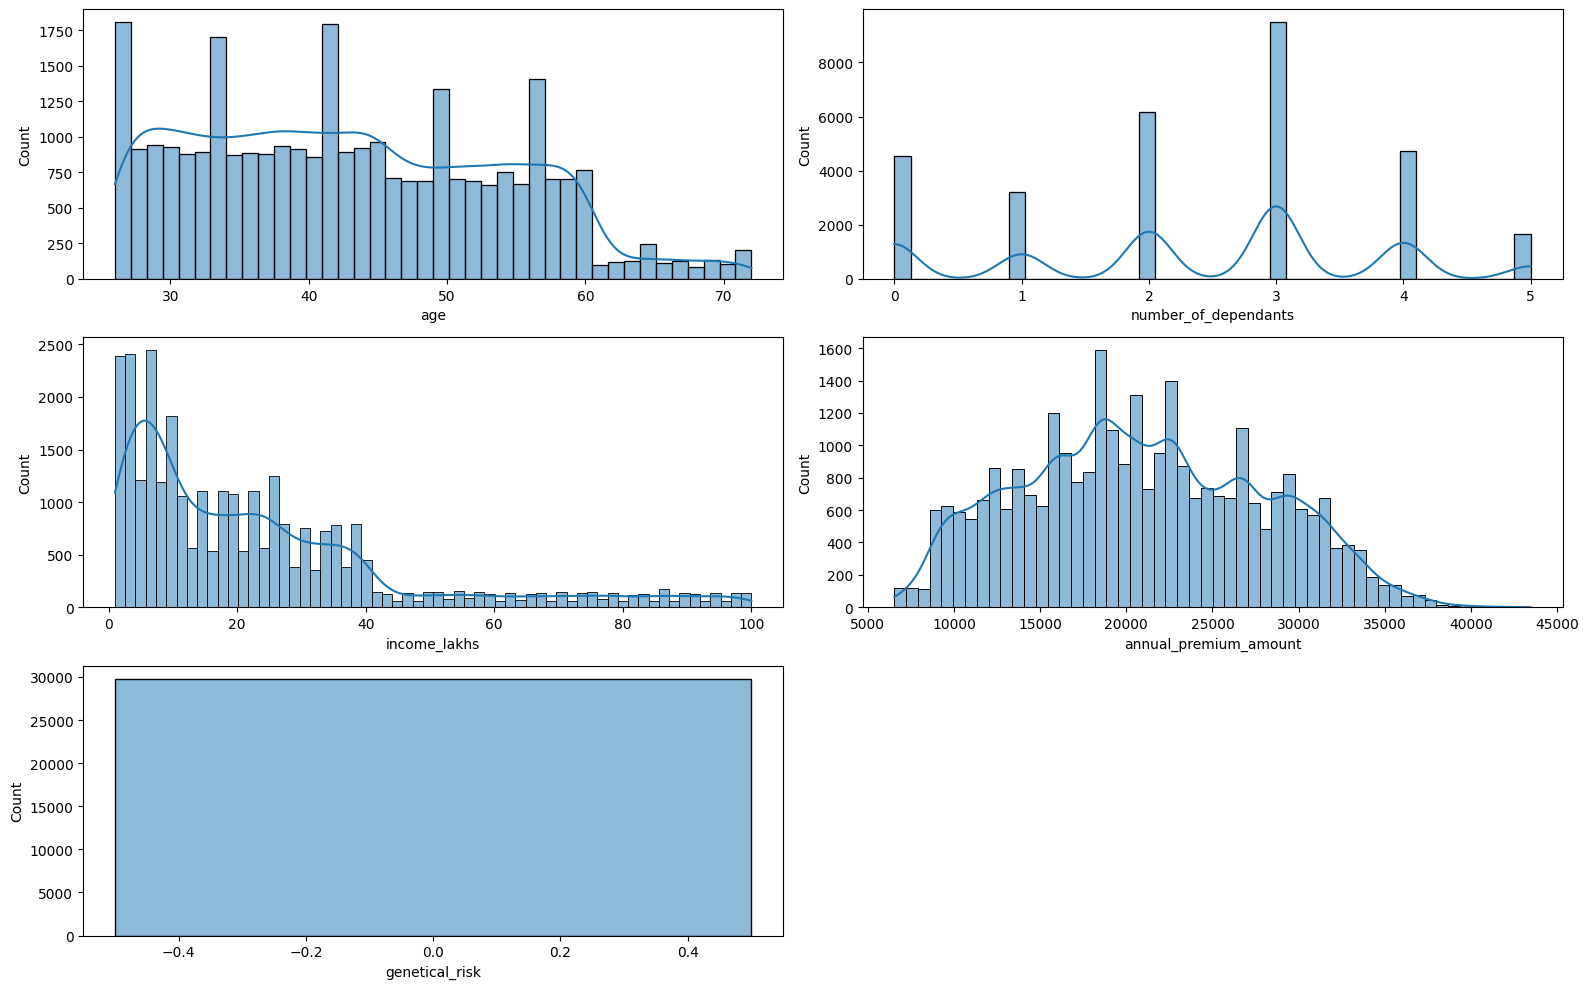

In [188]:
plt.figure(figsize=(16,10))
for idx, col in enumerate(numerical_columns):
    plt.subplot(3,2,idx+1)
    sns.histplot(data=df, x=col, kde=True)
plt.tight_layout()
plt.show() 

From the distribution we can understand that the columns age, income, annual premium are right skewed

In [189]:
categorical_columns = df.select_dtypes('object').columns
categorical_columns

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [190]:
# Exploring the categorical values

for col in categorical_columns:
    print(f"{col} - {df[col].unique()}")

gender - ['Male' 'Female']
region - ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status - ['Unmarried' 'Married']
bmi_category - ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status - ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status - ['Salaried' 'Self-Employed' 'Freelancer']
income_level - ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history - ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan - ['Bronze' 'Silver' 'Gold']


In [191]:
# The smoking status is not uniform

df['smoking_status'] = df['smoking_status'].replace({
                        'Smoking=0': 'No Smoking',
                        'Does Not Smoke': 'No Smoking',
                        'Not Smoking': 'No Smoking'
                    })
df['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

### Distribution of Categorical columns

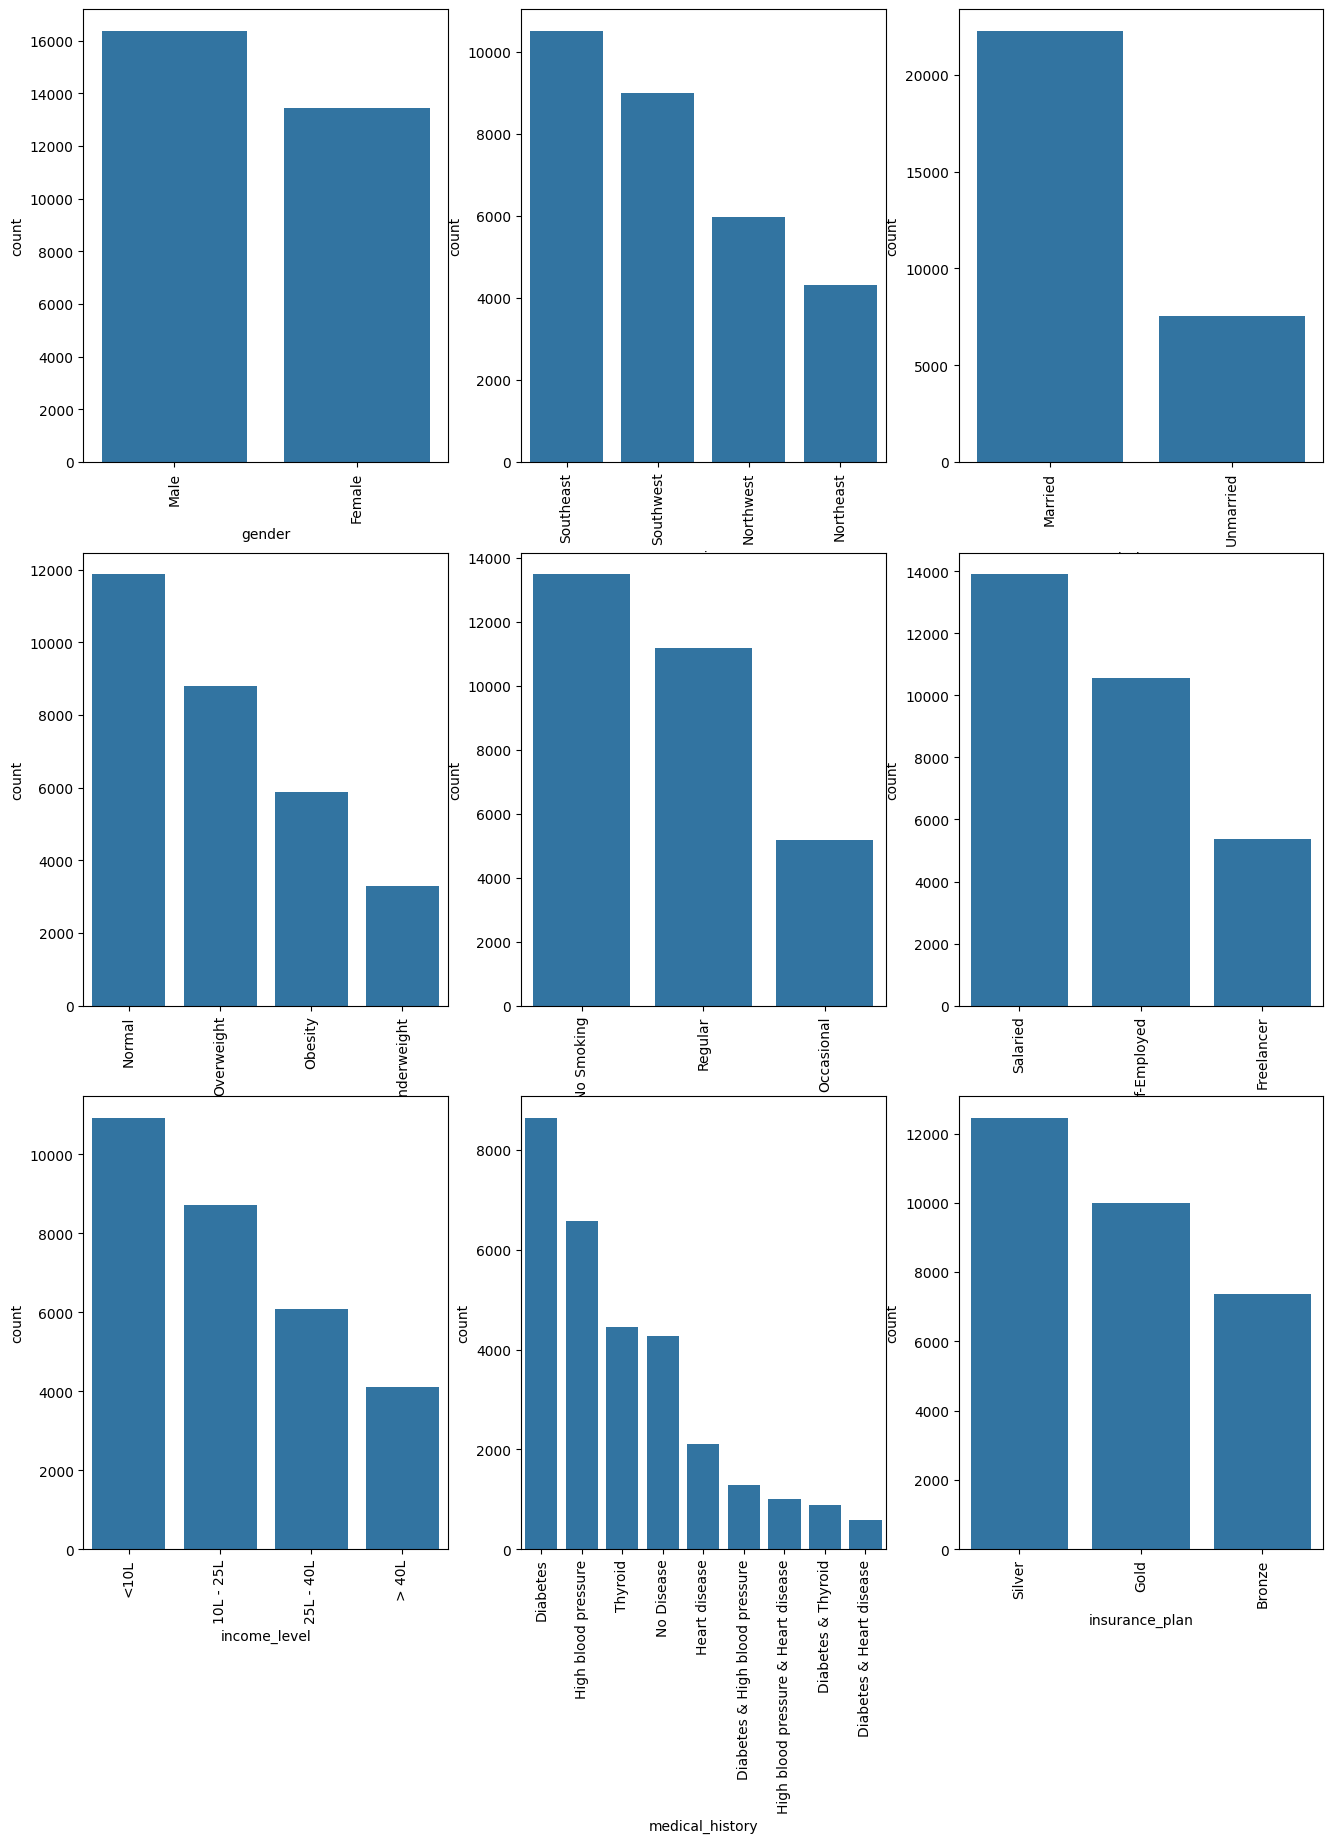

In [192]:
plt.figure(figsize=(16,20))
for idx, col in enumerate(categorical_columns):
    plt.subplot(3,3,idx+1)
    sns.barplot(df[col].value_counts())
    plt.xticks(rotation=90)
plt.show()

In [193]:
crosstab = pd.crosstab(df['income_level'], df['insurance_plan'])
crosstab

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,799,3554,4354
25L - 40L,301,2631,3142
<10L,6054,527,4341
> 40L,214,3287,618


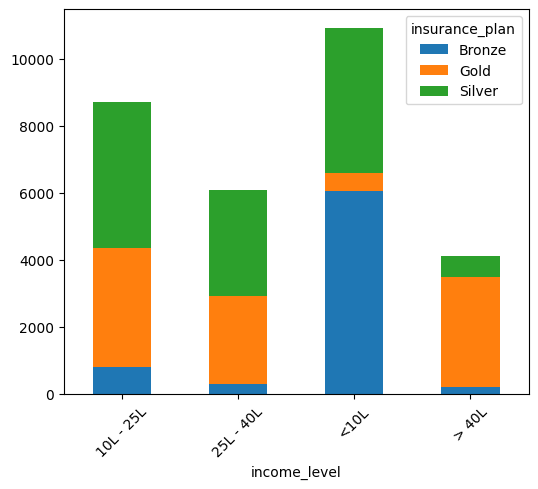

In [194]:
crosstab.plot(kind='bar', stacked=True, figsize=(6, 5))
plt.xticks(rotation=45)
plt.show()

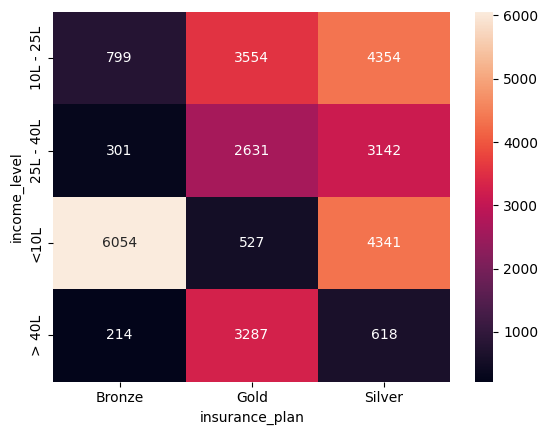

In [195]:
sns.heatmap(crosstab, annot=True, fmt='d')
plt.show()

# Feature Engineering

In [196]:
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount', 'genetical_risk'],
      dtype='object')

In [197]:
df.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [198]:
df['medical_history'] = df['medical_history'].str.lower()

In [199]:
# Max a person has 2 disease so extracting into seprate columns

df[['disease1', 'disease2']] = df.medical_history.str.split(' & ', expand=True)

df['disease2'] = df['disease2'].fillna('none')

In [200]:
# Define the risk scores for each condition
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df['total_risk_score'] = df['disease1'].map(risk_scores) + df['disease2'].map(risk_scores)

In [201]:
df['insurance_plan'] = df['insurance_plan'].map({"Bronze":1, "Silver":2, "Gold":3})

In [202]:
df['income_level'] = df['income_level'].map({"<10L":1, "10L - 25L":2, "25L - 40L":3, "> 40L":4})

In [203]:
cols_to_encode = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']

df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True, dtype=int)
df.head(2)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,diabetes,1,9053,0,diabetes,none,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,diabetes,1,16339,0,diabetes,none,...,1,0,0,1,0,0,0,1,1,0


In [204]:
# drop text columns

df.drop(columns=['medical_history', 'disease1', 'disease2'], inplace=True)

In [205]:
df.head(2)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0,6,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0,6,0,0,1,0,0,1,0,0,0,1,1,0


In [206]:
cols_to_norm = ['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan', 'total_risk_score', 'genetical_risk']
scaler = MinMaxScaler()
df[cols_to_norm] = scaler.fit_transform(df[cols_to_norm])
df.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,total_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,1,0.050505,0.0,9053,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,1,0.050505,0.0,16339,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,2,0.191919,0.5,18164,0.0,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,4,0.767677,1.0,20303,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,2,0.131313,0.0,15610,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


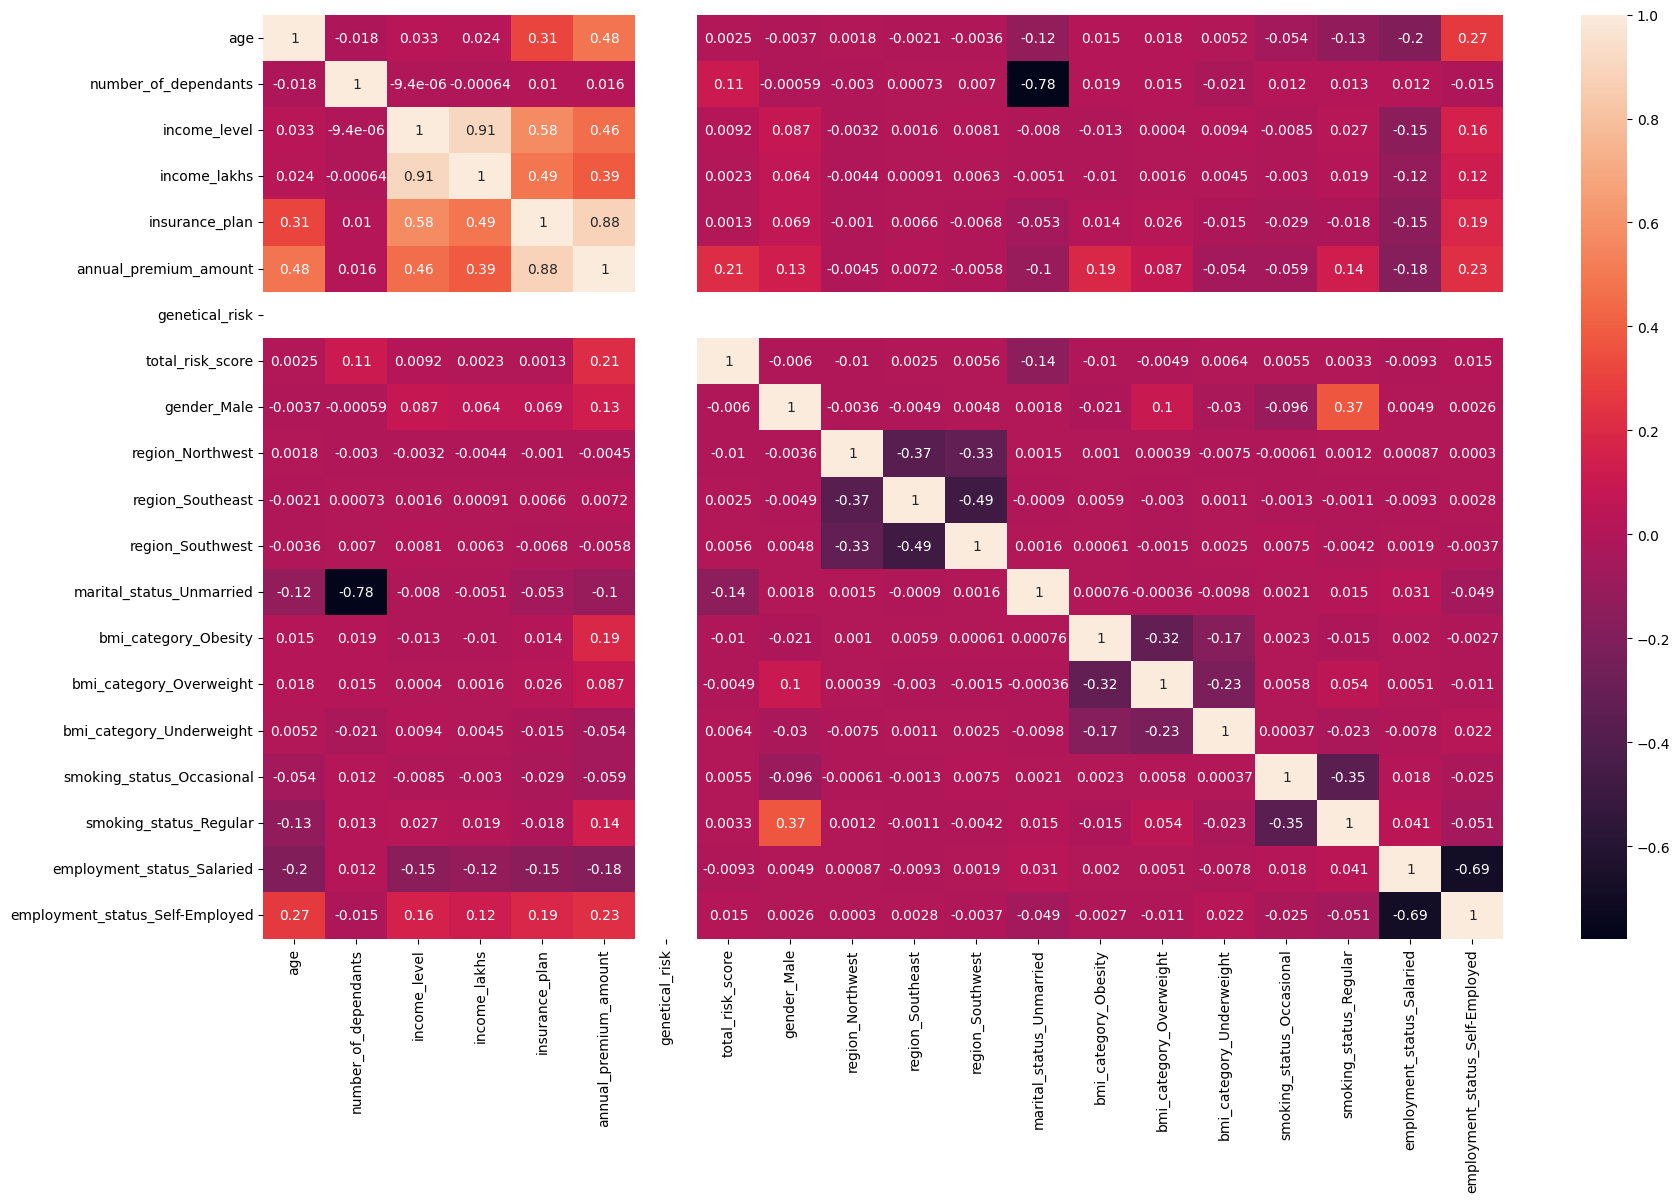

In [207]:
corr = df.corr()
plt.figure(figsize=(20,12))
sns.heatmap(corr, annot=True)
plt.show()

In [208]:
def get_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Features'] = data.columns
    vif_df['Values'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_df

In [209]:
get_vif(df.drop('annual_premium_amount', axis=1))

/Users/jey/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,Features,Values
0,age,3.863963
1,number_of_dependants,6.836022
2,income_level,28.028234
3,income_lakhs,10.200346
4,insurance_plan,5.281598
5,genetical_risk,NaN
6,total_risk_score,3.891340
7,gender_Male,2.612679
8,region_Northwest,2.169551
9,region_Southeast,3.058280


In [210]:
get_vif(df.drop(['annual_premium_amount', 'income_level'], axis=1))

/Users/jey/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,Features,Values
0,age,3.863055
1,number_of_dependants,6.278147
2,income_lakhs,2.678102
3,insurance_plan,4.574625
4,genetical_risk,NaN
5,total_risk_score,3.808345
6,gender_Male,2.591439
7,region_Northwest,2.123277
8,region_Southeast,2.979899
9,region_Southwest,2.708641


removing column - income_level since it has a high VIF value.

In [211]:
df.drop('income_level', axis=1, inplace=True)

In [212]:
X = df.drop('annual_premium_amount', axis=1)
y = df['annual_premium_amount']

# Model Training

### Model Training - Linear Regression

In [213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10) 

model = LinearRegression()
model.fit(X_train, y_train)
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

train_score, test_score

(0.9535019844995313, 0.9537335266411684)

In [214]:
model.intercept_

np.float64(5928.971289219118)

In [215]:
model.coef_

array([ 7.00993839e+03, -1.29905464e+03, -7.51439260e+02,  1.48438126e+04,
       -1.36424205e-12,  6.03146230e+03,  3.18537008e+01, -5.31379068e+01,
       -1.06240876e+01, -8.35793977e+00, -6.88544805e+02,  3.92973667e+03,
        1.98050820e+03,  6.22136667e+02,  8.49279293e+02,  2.80090611e+03,
       -5.04818658e+01,  2.50728645e+02])

In [216]:
X_train.columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'insurance_plan',
       'genetical_risk', 'total_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

In [217]:
feature_importance = pd.DataFrame(model.coef_, index=X_train.columns, columns=['value'])
feature_importance = feature_importance.sort_values(by='value', ascending=True)

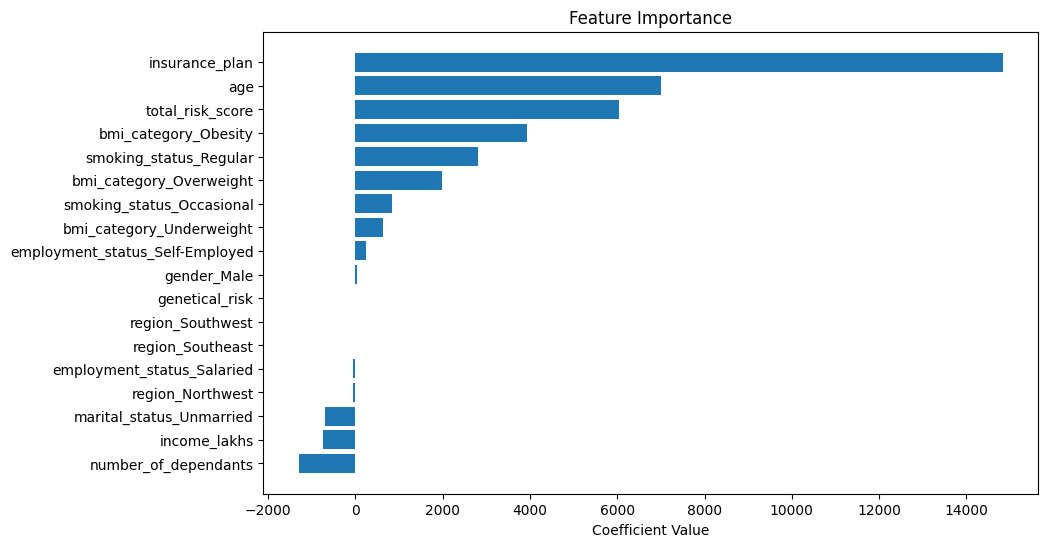

In [218]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance.index, feature_importance['value'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance')
plt.show()

In [219]:
y_pred = model.predict(X_test)

r2 = r2_score(y_pred, y_test)
mse = mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)

print(f'R-squared: {r2}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

R-squared: 0.951454920083461
Mean Squared Error: 2189347.890454598
Mean Absolute Error: 1127.649924992728


### Model Training - SVM

In [220]:
from sklearn.svm import SVR

model_svr = SVR()
model_svr.fit(X_train, y_train)
train_score = model_svr.score(X_train, y_train)
test_score = model_svr.score(X_test, y_test)

train_score, test_score

(0.11367747388936766, 0.11625685237584693)

### Model Training - XGBoost

In [221]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
train_score = model_xgb.score(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)

train_score, test_score

(0.9986096620559692, 0.998008131980896)

In [222]:
y_pred = model_xgb.predict(X_test)

r2 = r2_score(y_pred, y_test)
mse = mean_squared_error(y_pred, y_test)
mae = mean_absolute_error(y_pred, y_test)

print(f'R-squared: {r2}')
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

R-squared: 0.9980059266090393
Mean Squared Error: 94255.8125
Mean Absolute Error: 259.90008544921875


In [223]:
model_xgb = XGBRegressor()
params = {
    'n_estimators': [5, 10, 15],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.025, 0.5, 0.75]    
}

random_search = RandomizedSearchCV(model_xgb, params, n_iter=10, scoring='r2', cv=3)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...),
                   param_distributions={'learning_rate': [0.025, 0.5, 0.75],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [5, 10, 15]},
                   scoring='r2')

In [224]:
random_search.best_score_

np.float64(0.9978660742441813)

In [225]:
random_search.best_params_

{'n_estimators': 15, 'max_depth': 5, 'learning_rate': 0.5}

In [226]:
best_model = random_search.best_estimator_

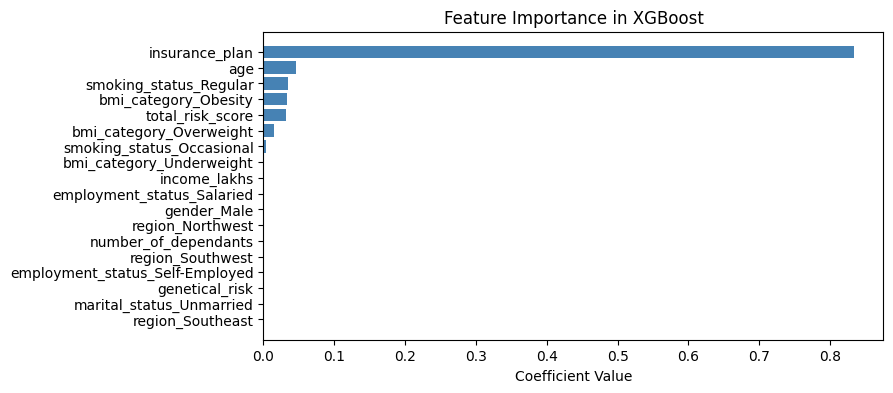

In [227]:
feature_importance = best_model.feature_importances_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

# Error Analysis

In [228]:
y_pred = best_model.predict(X_test)

diff = y_pred - y_test
diff_prc = diff*100/y_test

error_df = pd.DataFrame({
            "actual": y_test,
            "pred": y_pred,
            "difference": diff,
            "diff_prc": diff_prc
        })

In [229]:
error_df.head()

,actual,pred,difference,diff_prc
19713,26895,26580.417969,-314.582031,-1.169667
14750,22734,23202.968750,468.968750,2.062852
19932,21198,21564.265625,366.265625,1.727831
29643,9100,9139.040039,39.040039,0.429011
17076,26434,26580.417969,146.417969,0.553900


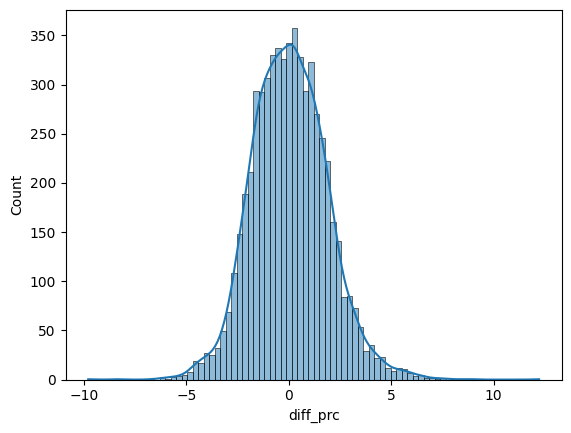

In [230]:
sns.histplot(error_df.diff_prc, kde=True)
plt.show()

In [231]:
extreme_error_df = error_df[np.abs(error_df.diff_prc) > 10] # difference >10%

In [232]:
extreme_error_pct = extreme_error_df.shape[0]*100/error_df.shape[0]
extreme_error_pct

0.016764459346186086

Error >10% is only 0.016%

# Export Model

In [233]:
from joblib import dump

dump(best_model, "artifacts/model_rest.joblib")

scaler_with_cols = {
    'scaler': scaler,
    'cols_to_scale': cols_to_norm
}

dump(scaler_with_cols, "artifacts/scaler_rest.joblib")

['artifacts/scaler_rest.joblib']